# RNNs as a generative model 

### Problem definition

<img align="left"      src='assets/gen_rnn_0.png' 
     width="200"/>
<br><br><br><br><br><br><br><br><br><br>

1. <p style='text-align: justify;'> We will train an RNN (LSTM or GRU; you choose one) that can predict the rest of the bottom half of an MNIST image given the top half. So, yes, this is a generative model that can "draw" handwritten digits. </p>

<img style="float: left; margin: 0px 0px 0px 30px;" 
     src='assets/gen_rnn_1.png' 
     width="200"/>
<br><br><br><br><br><br><br><br><br><br>

2. <p style='text-align: justify;'> As the first step, let’s divide every training image into 16 smaller patches. Since the original images are with 28×28 pixels, what I mean is that you need to chop off the image into 7 × 7 patches. There is no overlap between those patches. Above is an example from my implementation. It’s an image of number "5" obviously, but it’s just chopped into 16 patches. </p>


3. <p style='text-align: justify;'> Let’s give them an order. Let’s do it from the top left corner to the bottom right corner. Below is going to be the order of the patches. </p>

<img style="float: left; margin: 0px 0px 0px 30px;" 
     src='assets/gen_rnn_2.png' 
     width="200"/>
<br><br><br><br><br><br><br><br><br><br>


4. <p style='text-align: justify;'> Now that we have an order, we’ll use it to turn each MNIST image into a sequence of smaller patches. Although, below would be a potential way to turn these patches into a sequence, 
    <br> <img src='assets/gen_rnn_3.png' hight="50"/> 
I wouldn’t use this way exactly, because then it is a sequence of 2d arrays, not vectors.
</p>


5. <p style='text-align: justify;'> While I’ll keep the same order, to simplify our model architecture, we will vectorize each patch from 7×7 to a 49-dimensional vector. Finally, our sequence is a matrix X ∈ R 16×49, where 16 is the number of “time” steps. This is an input sequence to your RNN for training. </p>


6. <p style='text-align: justify;'> With a proper batch size, say 100, now an input tensor is defined as a 3D array of size 100 × 16 × 49. But, I’ll ignore the batch size in the equations below to keep the notation uncluttered.  </p>


7. <p style='text-align: justify;'> Train an RNN out of these sequences. here must be 50,000 such sequences, or 500 minibatches if your batch size is 100. I tried a couple of different model architectures but both worked quite well. The smallest one I tried was a 2×64 LSTM. I didn’t do any fancy things like gradient clipping, as the longest sequence length is still just 16. </p>


8. <p style='text-align: justify;'> Remember to add a dense layer, so that you can convert whatever choice of the LSTM or GRU hidden dimension back to 49. You may also want to use an activation function for your output units so that the output is bounded. </p>


9. <p style='text-align: justify;'> You need to train your RNN in a way that it can predict the next patch out of the so-far-observed patches. To this end, the LSTM should predict the next patch in the following manner:  
$$ (Y_{i+1,:},C_{i+1,:},H_{i+1,:}) = LSTM(X_{i,:},C_{i,:},H_{i,:}) $$

    where *C* and *H* denote the memory cell and hidden state, respectively (or with GRU *C* will be omitted), that are 0 when *t* = 0. To work as a predictive model, when you train, you need to compare $Y_{t,:}$ (the prediction) with $X_{t,:}$ (the next patch) and compute the loss (I used MSE as I'm lazy). </p>


10. <p style='text-align: justify;'> In other words, you will feed the input sequence $X_{1:15,:}$, (the full sequence except for the last patch) to the model, whose output $Y ∈ R^{15x49}$ will need to be compared to $X_{2:16,:}$, vector-by-vector. to compute the loss: 
$$ \mathcal{L} =\sum_{t=2}^{16} \sum_{d=1}^{49} D(X_{t,d}|| Y_{t-1,d}),$$
    𝑤ℎ𝑒𝑟𝑒 𝐷(.||.)𝑖𝑠 𝑡ℎ𝑒 𝑎𝑏𝑠𝑜𝑙𝑢𝑡𝑒 𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒 𝑏𝑒𝑡𝑤𝑒𝑒𝑛 𝑥 𝑎𝑛𝑑 𝑦 </p>
    
    
11. <p style='text-align: justify;'> Let's use the test set to validate the model at every epoch, to see if it overfits. If it starts to overfit, stop the training process early. It took from a few to tens of minutes to train the network. </p>


12. <p style='text-align: justify;'> Once your net converges, let's move on to the fun "generation" part. Pick up a test image that belongs to a digit class, and feed its first 8 patches to the trained model. It will generate eight patches ($Y ∈ R^{8x49}$). and two other vectors as the List memory cell and hidden states: $C_{9,:}$, $H_{9,:}$. Note that the dimension of <i>C</i> and <i>H</i> vectors depends on your choice of model complexity. </p>


13. <p style='text-align: justify;'> Then, run the model frame-by-frame, by feeding the last tnemory cell states, last hidden states and the <i> last predicted output as if it's the new input. </i> You will need to run this 7 times using a for loop, instead of feeding a sequence. Remember, for example, you don't know what to use as an input at <i>t</i> = 9, because we pretend like we don't know $X_{9,:}$, until you predict $Y_{8,:}$: 

$$(Y_{9,:},C_{10,:},H_{10,:}) = LSTM(Y_{8,:},C_{9,:},H_{9,:})$$
$$(Y_{10,:},C_{11,:},H_{11,:}) = LSTM(Y_{9,:},C_{10,:},H_{10,:})$$
$$(Y_{11,:},C_{12,:},H_{12,:}) = LSTM(Y_{10,:},C_{11,:},H_{11,:})$$
$$ ⋮ $$
$$(Y_{15,:},C_{16,:},H_{16,:}) = LSTM(Y_{14,:},C_{15,:},H_{15,:})$$ </p>


14. <p style='text-align: justify;'> Note that $Y_{15,:}$ is the prediction for your 16-th patch and e.g., $Y_{8,:}$ is the prediction for your 9-th patch, and so on. We will discard $Y_{1:7,:}$ as they are the predictions of patches that are already given (i.e., $t < 9$). Once again, you know, we pretend like the top half (patch 1 to 8) are given, while the rest (patch 9 to 16) are <i>NOT</i> known. </p>



____

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import torch
import random
import numpy as np
import pandas as pd
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torchvision import datasets
import torchvision.transforms as transforms

%matplotlib inline

### Loading dataset


In [3]:
#loading dataset from csv files

train_set_raw = pd.read_csv('/content/sample_data/mnist_train_small.csv', header=None)
train_set_raw /= 255
test_set_raw = pd.read_csv('/content/sample_data/mnist_test.csv', header=None)
test_set_raw /= 255

In [4]:
# train and test sets shapes 

print('train set shape:', train_set_raw.shape)
print('test set shape:',test_set_raw.shape)

train set shape: (20000, 785)
test set shape: (10000, 785)


In [5]:
# moving 9000 image from test set to train set

test_to_train = test_set_raw.iloc[:9000, :]
test_set_raw = test_set_raw.iloc[9000:, :]

train_set_raw = pd.concat([train_set_raw, test_to_train])

print('new train set shape:', train_set_raw.shape)
print('new test set shape:', test_set_raw.shape)

new train set shape: (29000, 785)
new test set shape: (1000, 785)


In [6]:
# making training set as a numpy array (and removing the lable from the training set)

train_set_raw_np = train_set_raw.to_numpy()

train_set_images = np.zeros((29000,28,28)).astype('double')

for i,idd in enumerate(train_set_raw_np):
  train_set_images[i] = idd[1:].reshape(28,28)

print('Final training set size:', train_set_images.shape)

Final training set size: (29000, 28, 28)


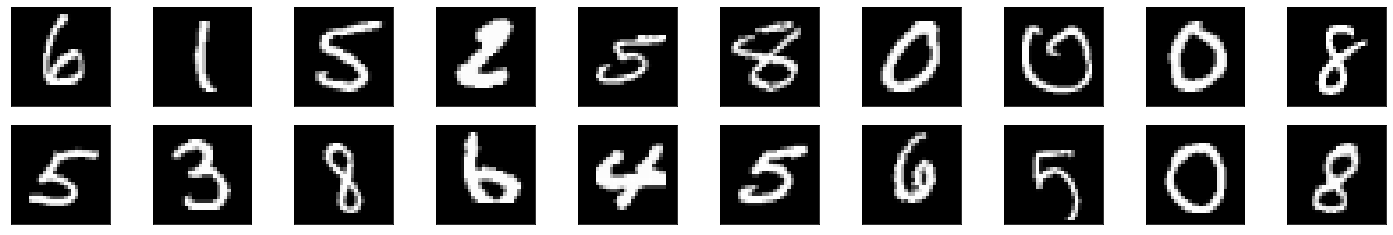

In [7]:
# visualizing dataset

random_factor = random.randint(0, train_set_raw.shape[0]-20) # to show different subset from the dataset each run

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  ax.imshow(train_set_images[idx+random_factor], cmap='gray')

### Images Slicing

In [8]:
train_set_sliced = np.zeros((29000,16,49)).astype('double')

for i,idd in enumerate(train_set_images):
  for x in range(4):
    for y in range(4):
      train_set_sliced[i,x*4+y] = idd[x*7:x*7+7,y*7:y*7+7].reshape(49)

print(train_set_sliced.shape)

(29000, 16, 49)


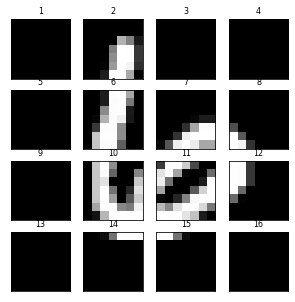

In [9]:
# visualizing sliced sample

random_factor1 = random.randint(0, train_set_sliced.shape[0])

fig = plt.figure(figsize=(5, 5))
for idx in np.arange(16):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  ax.imshow(train_set_sliced[random_factor1,idx,:].reshape(7,7), cmap='gray')
  ax.set_title(str(idx+1), fontdict={'fontsize': 8})

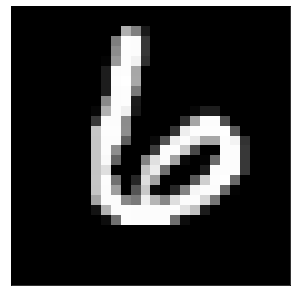

In [10]:
# visualizing unsliced sample

fig2 = plt.figure(figsize=(11,11))
ax = fig2.add_subplot(1, 2, 2, xticks=[], yticks=[])
ax.imshow(train_set_images[random_factor1,:].reshape(28,28), cmap='gray');

### Creating batches generator
Each image data is passed only with 15 mini image of the data, as there is no need to generate a mii image from the 16th smaller patch

$$ Loss = {{1\over16}} {{1\over49}} \sum_{i=1}^{15} \sum_{j=1}^{49} D(X_{i,j}|| X_{i+1,j})^2 \, ; \, where \, D(x||y) \, is \, the \, absolute \, distance \, between \, x \, and \, y$$ 

In [33]:
### Creating batches generator
def get_batches(arr, batch_size):
  '''Create a generator that returns batches of size
      batch_size from arr.
      
      Arguments
      ---------
      arr: Array you want to make batches from
      batch_size: Batch size, the number of sequences per batch
  '''
  
  ## Getting the number of batches we can make
  n_batches = arr.shape[0] // batch_size
  
  ## Keeping only enough characters to make full batches
  arr = arr[:n_batches * batch_size,:,:]
  
  ## Iterating over the batches 
  for n in range(n_batches):
    # The features
    x = arr[n:n+batch_size,:,:]
    # The targets, shifted by one
    y = np.zeros_like(x)
    y[:,:-1,:] = x[:,1:,:]
    y[:, -1, :]  = x[:, 0, :]
    yield x[:,:-1,:], y[:,:-1,:]

In [34]:
batches = get_batches(train_set_sliced, 100)
x, y = next(batches)

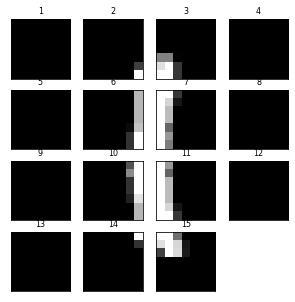

In [36]:
random_factor1 = random.randint(0, 100)

fig = plt.figure(figsize=(5, 5))
for idx in np.arange(15):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  ax.imshow(x[random_factor1,idx,:].reshape(7,7), cmap='gray')
  ax.set_title(str(idx+1), fontdict={'fontsize': 8})

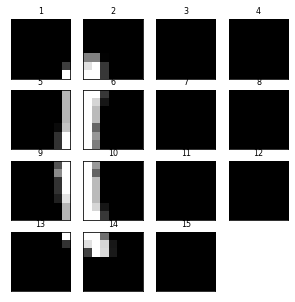

In [37]:
fig = plt.figure(figsize=(5, 5))
for idx in np.arange(15):
  ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
  ax.imshow(y[random_factor1,idx,:].reshape(7,7), cmap='gray')
  ax.set_title(str(idx+1), fontdict={'fontsize': 8})

------------

### Checking if GPU is available

In [38]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available.')

Training on GPU!


## Creating RNN model class

In [16]:
class ImgRNN(nn.Module):

  ''' Network Structure

      Arguments
      ---------
      n_hidden: The number of features in the hidden state h
      n_layers: Number of recurrent layers.
      drop_prob: dropout probability
      lr: learning rate
      mode: 0 -> use LSTM | else -> use GRU
  '''

    
  def __init__(self, n_hidden=128, n_layers=2,
                              drop_prob=0.5, lr=0.001, mode=0):
    super().__init__()
    self.drop_prob = drop_prob
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.lr = lr
    self.mode = mode
    
    ## defining the layers of the model

    if self.mode == 0:
      self.rnn = nn.LSTM(7*7, n_hidden, n_layers, dropout=drop_prob, batch_first=True)
    else:
      self.rnn = nn.RNN(7*7, n_hidden, n_layers, batch_first=True)
    
    self.dropout = nn.Dropout(drop_prob) 
    
    self.fc = nn.Linear(n_hidden, 7*7)

    self.activation = nn.ReLU()  


  def forward(self, x, hidden):
    ''' Forward pass through the network. 
        These inputs are x, and the hidden/cell state `hidden`. '''
            
    ## Getting the outputs and the new hidden state from the lstm
    batch_size = x.size(0)
    l_out, hidden = self.rnn(x, hidden)
    
    l_out = self.dropout(l_out)
    l_out = l_out.contiguous().view(-1, self.n_hidden)
    
    out = self.fc(l_out)
    out = self.activation(out)
    
    # return the final output and the hidden state
    return out, hidden


  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x n_hidden,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data
    
    if (train_on_gpu):
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                 weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
    else:
      hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                 weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
    
    return hidden
      

## Model training function

### Checkpoint
After training, will save the model so I can load it again later if I need to. Here I'm saving the parameters needed to create the same architecture, the hidden layer hyperparameters.

In [17]:
def Checkpoint(net, i, id):
  model_name = id + '_rnn_'+ str(i) +'_epoch.net'

  checkpoint = {'n_hidden': net.n_hidden,
                'n_layers': net.n_layers,
                'state_dict': net.state_dict()}

  with open('/content/drive/MyDrive/DeepLearning/' +  model_name, 'wb') as f:
    torch.save(checkpoint, f)

In [40]:
def train(net, data, epochs=2, batch_size=100, seq_length=15, lr=0.001, clip=5, val_frac=0.1, print_every=10, model_name_id = 'model1'):
  ''' Training a network 

      Arguments
      ---------
      net: CharRNN network
      data: image data to train the network
      epochs: Number of epochs to train
      batch_size: Number of mini-sequences per mini-batch, aka batch size
      seq_length: Number of character steps per mini-batch
      lr: learning rate
      clip: gradient clipping
      val_frac: Fraction of data to hold out for validation
      print_every: Number of steps for printing training and validation loss
      model_name_id: model id for saving model data

  '''
  net = net.double()
  net.train()

  opt = torch.optim.Adam(net.parameters(), lr=lr)
  criterion = nn.MSELoss()

  # create training and validation data
  val_idx = int(len(data)*(1-val_frac))
  data, val_data = data[:val_idx], data[val_idx:]

  if(train_on_gpu):
    net.cuda()

  counter = 0
  for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)
    #get_batches(train_set_sliced, batch_size)
    for x, y in get_batches(data, batch_size):
      counter += 1
      
      # make the images' mini patches data Torch tensors
      inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
      
      if(train_on_gpu):
        inputs, targets = inputs.cuda(), targets.cuda()

      # Creating new variables for the hidden state, otherwise
      # we'd backprop through the entire training history
      h = tuple([each.data for each in h])

      # zero accumulated gradients
      net.zero_grad()
      
      # get the output from the model
      output, h = net(inputs, h)

      
      # calculate the loss and perform backprop
      loss = criterion(output, targets.view(batch_size*seq_length,-1))
      loss.backward()      
      
      opt.step()
      
      # loss stats
      if counter % print_every == 0:
        # Get validation loss
        val_h = net.init_hidden(batch_size)
        val_losses = []
        net.eval()
        for x, y in get_batches(val_data, batch_size):
          # make the images' mini patches data Torch tensors
          x, y = torch.from_numpy(x), torch.from_numpy(y)
          
          # Creating new variables for the hidden state, otherwise
          # we'd backprop through the entire training history
          val_h = tuple([each.data for each in val_h])
          
          inputs, targets = x, y
          if(train_on_gpu):
            inputs, targets = inputs.cuda(), targets.cuda()

          output, val_h = net(inputs, val_h)
          val_loss = criterion(output, targets.view(batch_size*seq_length,-1))
      
          val_losses.append(val_loss.item())
        
        net.train() # reset to train mode after iterationg through validation data
        
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Step: {}...".format(counter),
              "Loss: {:.4f}...".format(loss.item()),
              "Val Loss: {:.4f}".format(np.mean(val_losses)))
    
    if e+1 == 1 or (e+1)%5 == 0:
        Checkpoint(net, e+1, model_name_id)

## Instantiating and training the model

In [20]:
%%time

# defining and printing the model architecture
n_hidden= 64
n_layers= 3
drop_prob=0.5
learning_rate = 0.0005

net2 = ImgRNN(n_hidden, n_layers, drop_prob)
print(net2)


# train the model
batch_size = 100
n_epochs = 20

train(net2, train_set_sliced, epochs=n_epochs, lr=learning_rate, print_every=100, model_name_id='hidden64_nLayers3_lr0001_v2')

ImgRNN(
  (rnn): LSTM(49, 64, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=49, bias=True)
  (activation): ReLU()
)
Epoch: 1/20... Step: 100... Loss: 0.0968... Val Loss: 0.1258
Epoch: 1/20... Step: 200... Loss: 0.0775... Val Loss: 0.0969
Epoch: 2/20... Step: 300... Loss: 0.0717... Val Loss: 0.0878
Epoch: 2/20... Step: 400... Loss: 0.0692... Val Loss: 0.0808
Epoch: 2/20... Step: 500... Loss: 0.0655... Val Loss: 0.0742
Epoch: 3/20... Step: 600... Loss: 0.0638... Val Loss: 0.0704
Epoch: 3/20... Step: 700... Loss: 0.0604... Val Loss: 0.0672
Epoch: 4/20... Step: 800... Loss: 0.0612... Val Loss: 0.0700
Epoch: 4/20... Step: 900... Loss: 0.0595... Val Loss: 0.0652
Epoch: 4/20... Step: 1000... Loss: 0.0584... Val Loss: 0.0664
Epoch: 5/20... Step: 1100... Loss: 0.0585... Val Loss: 0.0651
Epoch: 5/20... Step: 1200... Loss: 0.0576... Val Loss: 0.0619
Epoch: 5/20... Step: 1300... Loss: 0.0558... Val Loss: 0.0633
E

In [63]:
%%time

# defining and printing the model architecture
n_hidden= 256
n_layers= 4
learning_rate = 0.0005
drop_prob=0.7

net5 = ImgRNN(n_hidden, n_layers, drop_prob)
print(net5)


# train the model
batch_size = 290
n_epochs = 35

train(net5, train_set_sliced, batch_size=batch_size, epochs=n_epochs, lr=learning_rate, print_every=100, model_name_id='hidden256_nLayers2_lr0005_test2_')

ImgRNN(
  (rnn): LSTM(49, 256, num_layers=4, batch_first=True, dropout=0.7)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=256, out_features=49, bias=True)
  (activation): ReLU()
)
Epoch: 2/35... Step: 100... Loss: 0.0974... Val Loss: 0.1174
Epoch: 3/35... Step: 200... Loss: 0.0815... Val Loss: 0.0951
Epoch: 4/35... Step: 300... Loss: 0.0808... Val Loss: 0.0896
Epoch: 5/35... Step: 400... Loss: 0.0752... Val Loss: 0.0830
Epoch: 6/35... Step: 500... Loss: 0.0720... Val Loss: 0.0770
Epoch: 7/35... Step: 600... Loss: 0.0681... Val Loss: 0.0715
Epoch: 8/35... Step: 700... Loss: 0.0637... Val Loss: 0.0670
Epoch: 9/35... Step: 800... Loss: 0.0614... Val Loss: 0.0633
Epoch: 10/35... Step: 900... Loss: 0.0585... Val Loss: 0.0610
Epoch: 12/35... Step: 1000... Loss: 0.0555... Val Loss: 0.0586
Epoch: 13/35... Step: 1100... Loss: 0.0524... Val Loss: 0.0569
Epoch: 14/35... Step: 1200... Loss: 0.0510... Val Loss: 0.0548
Epoch: 15/35... Step: 1300... Loss: 0.0491... Val Loss: 0

In [59]:
%%time

# defining and printing the model architecture
n_hidden= 256
n_layers= 3
learning_rate = 0.0005
drop_prob=0.75

net6 = ImgRNN(n_hidden, n_layers, drop_prob)
print(net6)


# train the model
batch_size = 100
n_epochs = 40

train(net6, train_set_sliced, epochs=n_epochs, lr=learning_rate, print_every=100, model_name_id='hidden256_nLayers2_lr0005_test3_')

ImgRNN(
  (rnn): LSTM(49, 256, num_layers=3, batch_first=True, dropout=0.75)
  (dropout): Dropout(p=0.75, inplace=False)
  (fc): Linear(in_features=256, out_features=49, bias=True)
  (activation): ReLU()
)
Epoch: 1/40... Step: 100... Loss: 0.0981... Val Loss: 0.1260
Epoch: 1/40... Step: 200... Loss: 0.0781... Val Loss: 0.0965
Epoch: 2/40... Step: 300... Loss: 0.0757... Val Loss: 0.0902
Epoch: 2/40... Step: 400... Loss: 0.0690... Val Loss: 0.0783
Epoch: 2/40... Step: 500... Loss: 0.0667... Val Loss: 0.0753
Epoch: 3/40... Step: 600... Loss: 0.0645... Val Loss: 0.0691
Epoch: 3/40... Step: 700... Loss: 0.0605... Val Loss: 0.0668
Epoch: 4/40... Step: 800... Loss: 0.0593... Val Loss: 0.0650
Epoch: 4/40... Step: 900... Loss: 0.0559... Val Loss: 0.0608
Epoch: 4/40... Step: 1000... Loss: 0.0522... Val Loss: 0.0620
Epoch: 5/40... Step: 1100... Loss: 0.0522... Val Loss: 0.0601
Epoch: 5/40... Step: 1200... Loss: 0.0490... Val Loss: 0.0579
Epoch: 5/40... Step: 1300... Loss: 0.0502... Val Loss: 0.05

In [66]:
%%time

# defining and printing the model architecture
n_hidden= 256
n_layers= 3
learning_rate = 0.001
drop_prob=0.5

net8 = ImgRNN(n_hidden, n_layers, drop_prob)
print(net8)


# train the model
batch_size = 100
n_epochs = 25

train(net8, train_set_sliced, epochs=n_epochs, lr=learning_rate, print_every=100, model_name_id='hidden256_nLayers2_lr0005_test4_')

ImgRNN(
  (rnn): LSTM(49, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=49, bias=True)
  (activation): ReLU()
)
Epoch: 1/25... Step: 100... Loss: 0.0819... Val Loss: 0.0990
Epoch: 1/25... Step: 200... Loss: 0.0628... Val Loss: 0.0732
Epoch: 2/25... Step: 300... Loss: 0.0519... Val Loss: 0.0604
Epoch: 2/25... Step: 400... Loss: 0.0427... Val Loss: 0.0556
Epoch: 2/25... Step: 500... Loss: 0.0396... Val Loss: 0.0549
Epoch: 3/25... Step: 600... Loss: 0.0346... Val Loss: 0.0510
Epoch: 3/25... Step: 700... Loss: 0.0308... Val Loss: 0.0527
Epoch: 4/25... Step: 800... Loss: 0.0360... Val Loss: 0.0505
Epoch: 4/25... Step: 900... Loss: 0.0268... Val Loss: 0.0518
Epoch: 4/25... Step: 1000... Loss: 0.0252... Val Loss: 0.0539
Epoch: 5/25... Step: 1100... Loss: 0.0248... Val Loss: 0.0525
Epoch: 5/25... Step: 1200... Loss: 0.0220... Val Loss: 0.0535
Epoch: 5/25... Step: 1300... Loss: 0.0245... Val Loss: 0.0542

In [70]:
%%time

# defining and printing the model architecture
n_hidden= 256
n_layers= 3
learning_rate = 0.001
drop_prob=0.75

net9 = ImgRNN(n_hidden, n_layers, drop_prob)
print(net9)


# train the model
batch_size = 100
n_epochs = 25

train(net9, train_set_sliced, epochs=n_epochs, lr=learning_rate, print_every=100, model_name_id='hidden256_nLayers2_lr0005_test5_')

ImgRNN(
  (rnn): LSTM(49, 256, num_layers=3, batch_first=True, dropout=0.75)
  (dropout): Dropout(p=0.75, inplace=False)
  (fc): Linear(in_features=256, out_features=49, bias=True)
  (activation): ReLU()
)
Epoch: 1/25... Step: 100... Loss: 0.0820... Val Loss: 0.0929
Epoch: 1/25... Step: 200... Loss: 0.0669... Val Loss: 0.0778
Epoch: 2/25... Step: 300... Loss: 0.0619... Val Loss: 0.0705
Epoch: 2/25... Step: 400... Loss: 0.0548... Val Loss: 0.0628
Epoch: 2/25... Step: 500... Loss: 0.0547... Val Loss: 0.0624
Epoch: 3/25... Step: 600... Loss: 0.0511... Val Loss: 0.0591
Epoch: 3/25... Step: 700... Loss: 0.0474... Val Loss: 0.0576
Epoch: 4/25... Step: 800... Loss: 0.0493... Val Loss: 0.0572
Epoch: 4/25... Step: 900... Loss: 0.0451... Val Loss: 0.0553
Epoch: 4/25... Step: 1000... Loss: 0.0421... Val Loss: 0.0577
Epoch: 5/25... Step: 1100... Loss: 0.0408... Val Loss: 0.0557
Epoch: 5/25... Step: 1200... Loss: 0.0387... Val Loss: 0.0556
Epoch: 5/25... Step: 1300... Loss: 0.0408... Val Loss: 0.05

## Creating image generating functions

**predict** function works as follows: 
$$(Y_{i+1,:},C_{i+1,:},H_{i+1,:}) = LSTM(X_{i,:},C_{i,:},H_{i,:})$$


<br><br>
**sample** function works as follows:

 input patches = X[1-16]
 
$$for \: generated \: patches [1\!-\!8]  = X_{i,:} \\ 
for \: generated \: patches [9\!-\!16] = Y_{i+1,:} \\ where \: (Y_{i+1,:},C_{i+1,:},H_{i+1,:}) = LSTM(X_{i,:},C_{i,:},H_{i,:}) $$
 
Where Y is a generated mini patch

In [21]:
def predict(net, mini_image, h=None):
    ''' Given a mini image, predict the next mini image.
        Returns the predicted mini image and the hidden state.
    '''

    mini_image = mini_image.reshape(1,1,-1)

    # tensor inputs
    inputs = torch.from_numpy(mini_image)

    if(train_on_gpu):
        inputs = inputs.cuda()

    # detach hidden state from history
    h = tuple([each.data for each in h])

    # get the output of the model
    out, h = net(inputs, h)

    p = out.detach()

    if(train_on_gpu):
        p = p.cpu() # move to cpu if was in the gpu
          
    # return the predicted portion of the image and the hidden state
    return p.numpy().squeeze(), h

In [22]:
def sample(net, full_image):
    ''' Given an image, cut it into mini images and pass it to the predictor 
        Returns the predicted full and the original image.
    '''
        
    if(train_on_gpu):
          net.cuda()
    else:
          net.cpu()

    net.eval() # eval mode

    # slicing and saving the first 8 samples of the full image
    image_sliced = np.zeros((16,49))
    for x in range(2):
        for y in range(4):
            image_sliced[x*4+y] = full_image[x*7:x*7+7,y*7:y*7+7].reshape(49)


      # First off, run through the first 8 samples of the full image
    h = net.init_hidden(1) # resetting the hidden state
    for i in range(8):
        img, h = predict(net, image_sliced[i], h)

    i = 8
    image_sliced[i] = img
    i += 1

    # Now pass in the previous character and get a new one
    for ii in range(7):
        img, h = predict(net, image_sliced[-1], h)
        image_sliced[i] = img
        i += 1

    return image_sliced, full_image

In [23]:
def recombineSplitImage(split_image):
    ''' Given an splited image, recobine the 16 mini images into one image 
        Returns a combined virsion of the image.
    '''

    combinedImage = np.zeros((28,28))

    for x in range(4):
        for y in range(4):
            combinedImage[x*7:x*7+7,y*7:y*7+7] = split_image[x*4+y].reshape(7,7)

    return combinedImage

## Preprocessing testing images

In [24]:
test_set_raw_np = test_set_raw.to_numpy()

test_set_images = np.zeros((1000,28,28)).astype('double')

for i,idd in enumerate(test_set_raw_np):
    test_set_images[i] = idd[1:].reshape(28,28)

In [25]:
# getting count of each labelin the testing set

labels = test_set_raw_np[:,0] * 255 # to the labels correctly as I divided by 255 to make the image pixels in ange [0.0,1.0]

print('Testing set:-\n')

l,c = np.unique(labels, return_counts=True)
for a,b in zip(l,c):
    print(int(a), '\b\'s count is:',b)

Testing set:-

0 's count is: 102
1 's count is: 119
2 's count is: 99
3 's count is: 102
4 's count is: 92
5 's count is: 85
6 's count is: 102
7 's count is: 115
8 's count is: 94
9 's count is: 90


In [26]:
# numbers will hold indexes for each digit 

numbers = []

for i in range(10):
    numbers.append(list(np.squeeze(np.where(labels == i))))

### Loading a saved model

In [47]:
# loading a saved model

print('Performance after training for 20 epochs\n\n')

with open('/content/drive/MyDrive/DeepLearning/hidden256_nLayers2_lr0005_rnn_5_epoch.net', 'rb') as f:
    if(train_on_gpu):
        checkpoint = torch.load(f, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(f)
    
loaded = ImgRNN(n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

Performance after training for 20 epochs




<All keys matched successfully>

## Model testing on 100 images (10 for each digit)


chosen model:

`ImgRNN(
  (rnn): LSTM(49, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=49, bias=True)
  (activation): ReLU()
)`

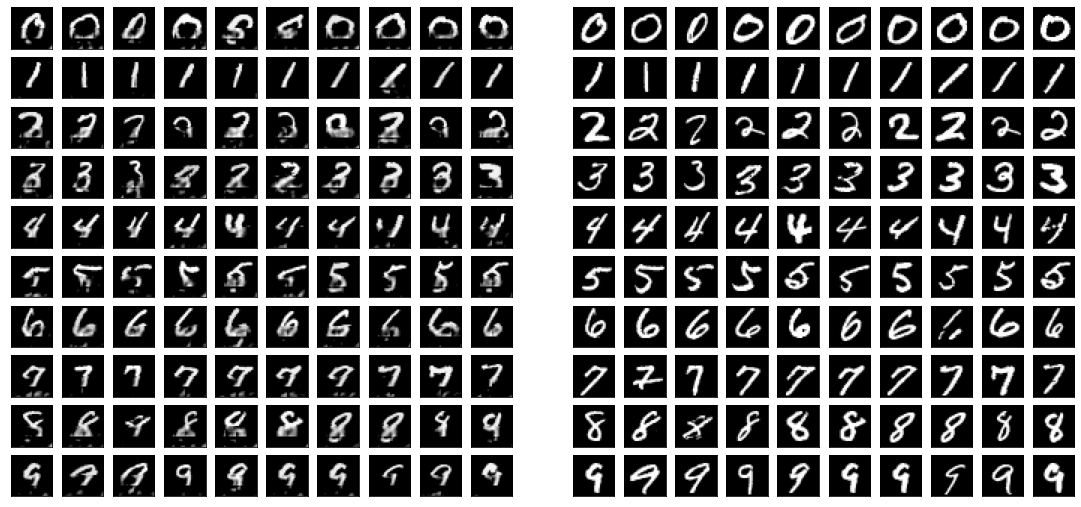

In [78]:
model = net8

count = 10  # each digit count to test on

fig = plt.figure(figsize=(20,9))
for i in range(10): # looping over each number
    for j in range(count):
        random_factor = random.randint(0, len(numbers[i]) - 1)

        img1, img2 = sample(model.double(), test_set_images[numbers[i][random_factor]])

        ax = fig.add_subplot(10, 22, i*22 + j + 1, xticks=[], yticks=[])
        ax.imshow(recombineSplitImage(img1), cmap='gray');

        ax = fig.add_subplot(10, 22, i*22 + j + 12, xticks=[], yticks=[])
        ax.imshow(img2, cmap='gray');